In [39]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import itertools
import re
import unicodedata
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(8, 10))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Notes on Prepare/ Acquire: Create the URL's

- Focused on URL's that were identified as JavaScript or Python
- Opened up searh URL on GitHub, added URLs that fit discription untill 105 were sampled
- Ended on search page 39

## Acquire/Prepare:

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    35
python        28
Name: language, dtype: int64
javascript    11
python        10
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered
22,javascript,ng6 de facto starter repo building scalable ap...
1,javascript,repo deprecated mixed mode found httpsgithubco...
59,javascript,diyhue hue bridge emulator project emulates ph...
5,python,ipython productive interactive computing overv...
2,javascript,supporting vuejs vuejs mitlicensed open source...


## Explore:


1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

### Question #1. What are the most common words in READMEs?

In [4]:
# Break it down by language
#train['language'] = train['language'].str.strip()

In [5]:
# Create a corpus of all text
all_words = ' '.join(train.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)

In [6]:
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

file       309
use        265
video      216
git        175
example    161
dtype: int64

#### Javascript only

In [7]:
# Break it down by language (Javascript)
mask = train.language == 'javascript'
java_df = train[mask]
# Create a corpus of all text
all_words = ' '.join(java_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

file        128
use          90
meta         75
option       74
callback     70
dtype: int64

In [8]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
file,128
use,90
meta,75
option,74
callback,70
true,68
install,64
npm,63
function,63
telegram,60


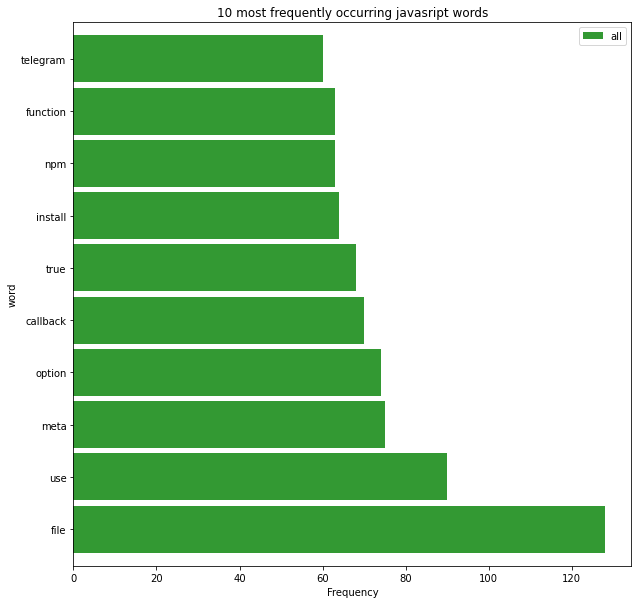

In [9]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='green', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring javasript words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

****

#### Python Only

In [10]:
# Break it down by language (Python)
mask = train.language == 'python'
python_df = train[mask]
python_df.head()
# Create a corpus of all text
all_words = ' '.join(python_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

video        213
file         181
use          175
youtubedl    147
git          147
dtype: int64

In [11]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
video,213
file,181
use,175
youtubedl,147
git,147
format,112
python,111
download,110
example,109
run,102


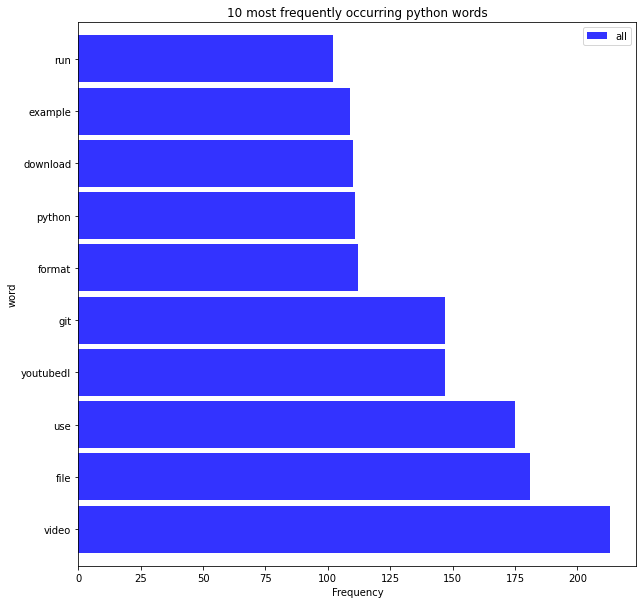

In [12]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='blue', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring python words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

#### Combined 

In [13]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
file,309,128,181
use,265,90,175
video,216,3,213
git,175,28,147
example,161,52,109
run,158,56,102
using,148,48,100
youtubedl,147,0,147
code,136,35,101
option,133,74,59


In [14]:
# Any words specific only to javascript and never in python?
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python
callback,70,70,0
npm,63,63,0
params,51,51,0
skype,47,47,0
ipfs,38,38,0
browserpass,37,37,0
err,32,32,0
redux,30,30,0
const,29,29,0
couchdb,28,28,0


In [15]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
youtubedl,147,0,147
model,68,0,68
commits,54,0,54
deeplift,52,0,52
gita,48,0,48
score,41,0,41
ipython,40,0,40
emotion,38,0,38
lineprofiler,38,0,38
paper,36,0,36


In [16]:
# These might be words to excude to make modeling easier
word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(20)

,all,javascript,python
request,108,54,54
developer,34,17,17
library,32,16,16
working,24,12,12
found,24,12,12
easily,20,10,10
parameter,20,10,10
control,18,9,9
course,16,8,8
authentication,14,7,7


****
#### Takeaway:

`1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)`   
`2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)`    
`3. Common words, bad for modeling (file, use, run, using, example)`     
`4. Most common words (Corpus) = Most Common words for specific languages`    

`May remove flie, use, run, using, example from corpus`   

****

### Question #2. What does the distribution of IDFs look like for the most common words?

In [17]:
#Inverse Documnet Frequency; a measure based on in how many documents will a word appear.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)

In [18]:
# Get vocabularies.
tfidf.vocabulary_

{'repo': 34,
 'using': 46,
 'build': 3,
 'feature': 14,
 'support': 40,
 'check': 5,
 'use': 43,
 'file': 15,
 'dont': 12,
 'need': 28,
 'change': 4,
 'new': 29,
 'way': 49,
 'time': 41,
 'directory': 11,
 'run': 37,
 'like': 24,
 'read': 33,
 'install': 20,
 'list': 26,
 'available': 2,
 'used': 44,
 'link': 25,
 'version': 47,
 'default': 10,
 'want': 48,
 'example': 13,
 'following': 16,
 'create': 8,
 'make': 27,
 'project': 32,
 'ha': 18,
 'issue': 22,
 'installation': 21,
 'request': 36,
 'help': 19,
 'user': 45,
 'open': 31,
 'note': 30,
 'work': 50,
 'update': 42,
 'github': 17,
 'command': 7,
 'automatically': 1,
 'source': 39,
 'add': 0,
 'license': 23,
 'set': 38,
 'code': 6,
 'repository': 35,
 'data': 9}

***
#### Takeaway:
`1. Many of the words are overlap are found in many documents, further evidence that they should be removed befor modeling`

***

### Question #3. Does the length of the README vary by programming language?

In [19]:
# Count lenght of readme text
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train.head()

,language,text_filtered,doc_length
22,javascript,ng6 de facto starter repo building scalable ap...,5145
1,javascript,repo deprecated mixed mode found httpsgithubco...,282
59,javascript,diyhue hue bridge emulator project emulates ph...,4046
5,python,ipython productive interactive computing overv...,3431
2,javascript,supporting vuejs vuejs mitlicensed open source...,2047


In [20]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]
python_train.shape, javascript_train.shape

((28, 3), (35, 3))

In [21]:
#Ave doc_lenth(python)
pmean= (python_train.doc_length).mean()
pmean

6230.785714285715

In [22]:
#Ave doc_lenth(javascript)
jmean=(javascript_train.doc_length).mean()
jmean

2935.542857142857

#### Hypothesis Test (2 Sample T-Test)

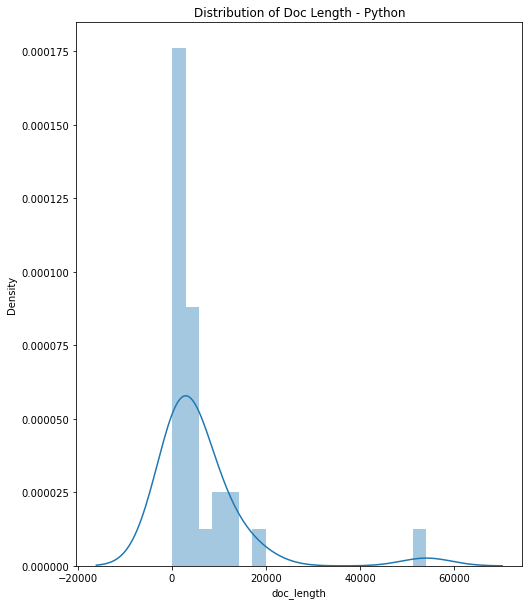

In [23]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(python_train.doc_length)
plt.title('Distribution of Doc Length - Python')
plt.show()

In [24]:
python_train.describe()

,doc_length
count,28.000000
mean,6230.785714
std,10457.168229
min,70.000000
25%,1223.000000
50%,3086.500000
75%,5750.000000
max,54017.000000


***

`Python Data is NOT evenly distributed`

***

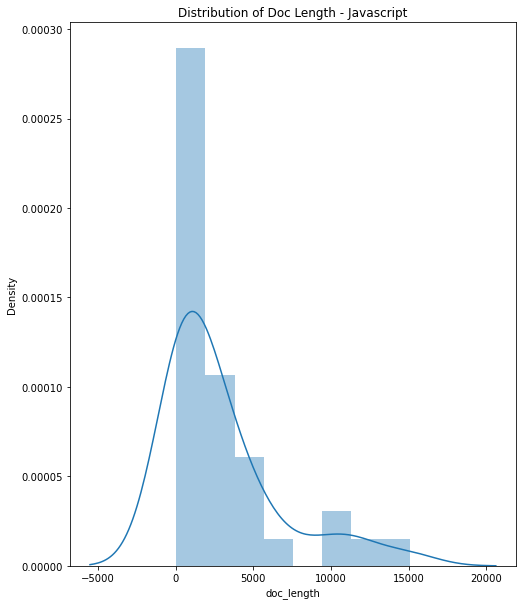

In [25]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(javascript_train.doc_length)
plt.title('Distribution of Doc Length - Javascript')
plt.show()

In [26]:
javascript_train.describe()

,doc_length
count,35.000000
mean,2935.542857
std,3764.245861
min,42.000000
25%,363.500000
50%,1212.000000
75%,3731.500000
max,15053.000000


***

`Javascript Data is NOT evenly distributed`

***

In [27]:
# Variance (2 Sample T-Test)
print(python_train.doc_length.var())
print(javascript_train.doc_length.var())

109352367.35978836
14169546.902521009


***
`Variance is not equal, need to set in function call`
***

#### Null and Alternate

In [28]:
null = "there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md"
alternate = "there is a statisically significant difference between between the length of python repo README.md and javascript repo README.md"

In [29]:
# I want a 95% confidence interval
alpha = 0.05

#### T-Test

In [30]:

t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = 1.587
p = 0.122
is p < alpha?  False
is t > 0?  True
We fail to reject that there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md


***

In [31]:
python_train.shape, javascript_train.shape

((28, 3), (35, 3))

### Question #4. Do different programming languages use a different number of unique words?

In [46]:
# Create list of word lists(python_train)
pwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in python_train.text_filtered]
# Combine those lists in to a single list
pwords = list(itertools.chain.from_iterable(pwords))
# Returns words unique to python
unique_pwords = list(set(pwords) - set(jwords))

# Create list of word lists(javascript_train)
jwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in javascript_train.text_filtered]
# Combine those lists in to a single list
jwords = list(itertools.chain.from_iterable(jwords))
# Returns words unique to python
unique_jwords = list(set(jwords) - set(pwords))

#### Words Unique to Python Repositories

In [52]:
print(len(unique_pwords))
unique_pwords

4123


['httpwwwsqlalchemyorgdocs',
 '10079',
 'preventing',
 'selfhtmlsearchregexrh1h1',
 'slows',
 'empty',
 'span',
 'artist',
 'executable',
 'gitoftheseussurvivalplot',
 'synology',
 'skipdownload',
 'matefinding',
 'erased',
 'juanpotato',
 'n75573g1d0487f',
 'hierarchical',
 'hikvision',
 'legacyinitrdextsh',
 'duplicate',
 'sublang',
 'regularly',
 'unifi',
 'leftassociative',
 'fakemissingtagger',
 'pic',
 'socalled',
 'capitulationinducing',
 'hydratim',
 'wav',
 'reposts',
 'distribute',
 'clientside',
 'four',
 'grayscale',
 'accommodate',
 'vcodec',
 'normalize',
 'weighted',
 'otfs',
 'starttime',
 'mutlimodal',
 'monospace',
 'httpsarxivorgabs170402685',
 'chroot',
 'preconfigured',
 'comet',
 'lovelace',
 'series',
 'edwardbetts',
 'bypassing',
 'douban',
 '07062020',
 'httpssomevideo',
 'binux',
 'surrogate',
 '20091231',
 'demonstrated',
 'toggled',
 'unicodeliterals',
 'honolulu',
 '20160821',
 'fps',
 'magenta',
 '11072020',
 'ssh',
 'fragment',
 'dublin',
 'seeing',
 'rem

In [53]:
print(len(unique_jwords))
unique_jwords

2269


['alerthello',
 'placed',
 'cyclomatic',
 'httpbitlypiterunited',
 'aliceattachmentinsertnew',
 'akihabara',
 'httpsgitterimphpuayii',
 'ad',
 'awesome',
 'metanpm',
 'httpsgitterimsalesforcerusalesforceru',
 'nodeua',
 'fund',
 'filesig',
 'begin',
 'ipfsobjectputobj',
 'benefiting',
 'ben',
 'httpbitlyjavatalksby',
 'cedric',
 'nanodbcreatename',
 'blitted',
 'ipfsstatsrepooptions',
 'clientappcomponents',
 'russpeaking',
 'httpgooglznsgaf',
 'parser',
 'robot',
 'thresholdmaxcyc',
 'gm5ybhjwros7zjtiyujtbu',
 'ipfsobjectstatmultihash',
 'vuejs',
 'uis',
 'qtcreator',
 'dortanialogoclearpng',
 'permodule',
 'sidoh',
 'reactjsnet',
 'serverside',
 'docnames',
 'classp3',
 'reusing',
 'flash',
 'distclijs',
 'installcomplexityreport',
 'selectedwrestler',
 'jump',
 'httpsgitterimphpualaravel',
 'famous',
 'urlimport',
 'webdevelopment',
 'sprite',
 'isopen',
 'directoryfile',
 'chromezip',
 'dbattachmentgetdocname',
 'codingteam',
 'protoschool',
 'eventual',
 'rooij',
 'reportformat',


***
#### Takwaway:
`There appear to be more words unique to python repositories.  This makes sense because the length of python README.md text is statistically longer then javascript README.md text.`
***

## Modeling: